In [ ]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

Обучение RNN
Эпоха [1/20], Потери: 0.0765
Эпоха [2/20], Потери: 0.0110
Эпоха [3/20], Потери: 0.0052
Эпоха [4/20], Потери: 0.0094
Эпоха [5/20], Потери: 0.0208
Эпоха [6/20], Потери: 0.0139
Эпоха [7/20], Потери: 0.0145
Эпоха [8/20], Потери: 0.0090
Эпоха [9/20], Потери: 0.0097
Эпоха [10/20], Потери: 0.0124
Эпоха [11/20], Потери: 0.0209
Эпоха [12/20], Потери: 0.0168
Эпоха [13/20], Потери: 0.0278
Эпоха [14/20], Потери: 0.0135
Эпоха [15/20], Потери: 0.0136
Эпоха [16/20], Потери: 0.0212
Эпоха [17/20], Потери: 0.0168
Эпоха [18/20], Потери: 0.0139
Эпоха [19/20], Потери: 0.0062
Эпоха [20/20], Потери: 0.0124
Обучение LSTM
Эпоха [1/20], Потери: 0.4787
Эпоха [2/20], Потери: 0.0683
Эпоха [3/20], Потери: 0.0073
Эпоха [4/20], Потери: 0.0177
Эпоха [5/20], Потери: 0.0153
Эпоха [6/20], Потери: 0.0113
Эпоха [7/20], Потери: 0.0169
Эпоха [8/20], Потери: 0.0089
Эпоха [9/20], Потери: 0.0094
Эпоха [10/20], Потери: 0.0264
Эпоха [11/20], Потери: 0.0228
Эпоха [12/20], Потери: 0.0095
Эпоха [13/20], Потери: 0.0117
Э

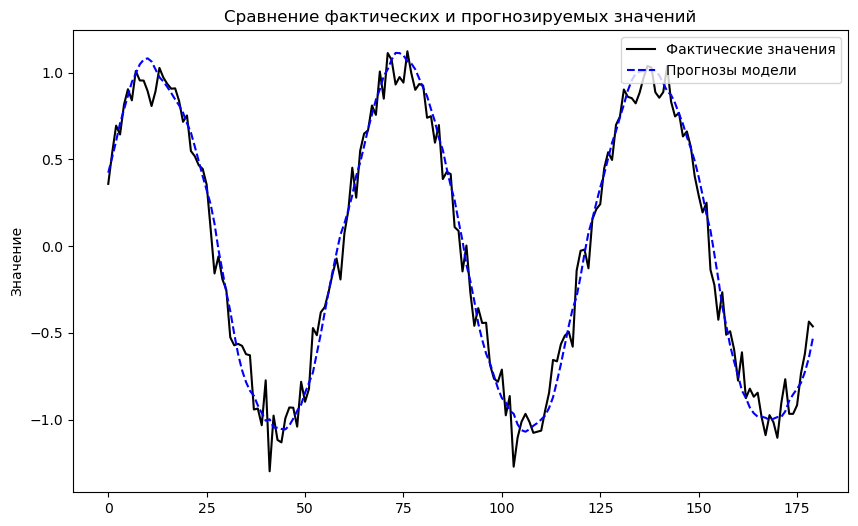

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Генерация набора данных временных последовательностей
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Определение модели RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Модифицированная модель с LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Генерация синусоидальных данных с шумом
seq_length = 20
n_samples = 1000
x = np.linspace(0, 100, n_samples)
data = np.sin(x) + 0.1 * np.random.normal(size=len(x))  # Синусоида с шумом

# Разделение данных на тренировочный и тестовый наборы
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Создание датасетов и загрузчиков данных
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

input_size = 1
hidden_size = 50
output_size = 1

# Функция для обучения модели
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.view(-1, seq_length, input_size)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

        print(f"Эпоха [{epoch+1}/{epochs}], Потери: {loss.item():.4f}")

# Обучение RNN
print("Обучение RNN")
rnn_model = RNN(input_size, hidden_size, output_size)
train_model(rnn_model, train_dataloader, epochs=20)

# Обучение LSTM
print("Обучение LSTM")
lstm_model = LSTM(input_size, hidden_size, output_size)
train_model(lstm_model, train_dataloader, epochs=20)

# Проверка модели на тестовом наборе данных
model = lstm_model
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.view(1, seq_length, input_size)
        pred = model(x).item()
        predictions.append(pred)
        actual.append(y.item())

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(actual, label="Фактические значения", linestyle='-', color='black')
plt.plot(predictions, label="Прогнозы модели", linestyle='--', color='blue')
plt.legend(loc='upper right')
plt.ylabel("Значение")
plt.title("Сравнение фактических и прогнозируемых значений")
plt.show()


In [ ]:
#Из лекции 7
# Задание (файл 2)
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# (1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
# "экспоненциальное среднее".

C:\Users\darya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\darya\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\darya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\darya\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\darya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:9

Сравнение параметров p, d, q:
    p  d  q           MSE
0   1  1  1  2.957952e+00
5   1  2  3  3.368997e+00
4   1  2  2  3.421576e+00
21  3  2  1  3.428490e+00
12  2  2  1  3.435695e+00
14  2  2  3  3.498150e+00
22  3  2  2  3.530848e+00
11  2  1  3  3.548312e+00
13  2  2  2  3.809935e+00
9   2  1  1  4.093656e+00
1   1  1  2  4.095683e+00
10  2  1  2  4.103650e+00
18  3  1  1  4.120522e+00
20  3  1  3  4.120925e+00
2   1  1  3  4.122089e+00
19  3  1  2  4.218217e+00
3   1  2  1  4.759807e+00
7   1  3  2  9.575610e+02
23  3  2  3  1.414438e+04
26  3  3  3  3.131500e+05
25  3  3  2  6.286359e+05
16  2  3  2  6.541357e+05
24  3  3  1  1.273734e+06
15  2  3  1  4.190085e+06
6   1  3  1  1.509744e+07
8   1  3  3  7.053886e+07
17  2  3  3  7.578427e+07

Лучшие параметры ARIMA: (1, 1, 1) с MSE: 2.96


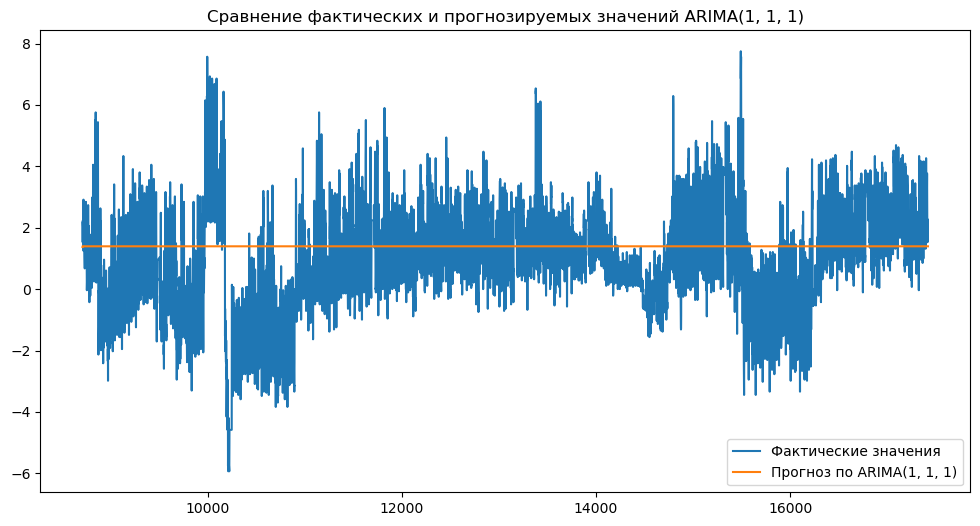

MSE для итеративного предсказания: 0.58


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Параметры для исследования
P, D, Q = 3, 0, 0

# Загрузка и разбиение данных
df = pd.read_csv('ETTh1.csv')
N = 2
dfs = np.array_split(df, N)

train, test = dfs[0], dfs[1]
train_values = train['MULL']
test_values = test['MULL']

# Функция для изменения параметров ARIMA и выбора лучшей модели
def change_params(train_values, test_values):
    results = []
    best_mse = float('inf')
    best_order = None
    best_model = None

    # Перебор возможных значений p, d, q
    for p in range(1, 4):
        for d in range(1, 4):
            for q in range(1, 4):
                try:
                    # Строим модель ARIMA
                    model = ARIMA(train_values, order=(p, d, q))
                    fitted_model = model.fit()
                    
                    # Прогнозируем
                    start = len(train_values)
                    end = len(train_values) + len(test_values) - 1
                    predictions = fitted_model.predict(start=start, end=end)
                    
                    # Оценка модели
                    mse = mean_squared_error(test_values, predictions)
                    results.append({'p': p, 'd': d, 'q': q, 'MSE': mse})
                    
                    # Сохраняем модель с минимальной ошибкой
                    if mse < best_mse:
                        best_mse = mse
                        best_order = (p, d, q)
                        best_model = fitted_model
                except Exception:
                    continue

    # Сортируем результаты по MSE
    results_df = pd.DataFrame(results).sort_values(by='MSE')
    return best_model, best_order, best_mse, results_df

# Выполнение перебора и нахождение лучших параметров
best_model, best_order, best_mse, results_df = change_params(train_values, test_values)

# Печать сравнений параметров
print("Сравнение параметров p, d, q:")
print(results_df)

# Печать лучших параметров и ошибки
print(f"\nЛучшие параметры ARIMA: {best_order} с MSE: {best_mse:.2f}")

# Прогнозирование на основе лучших параметров
start = len(train_values)
end = len(train_values) + len(test_values) - 1
predictions = best_model.predict(start=start, end=end)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test_values, label='Фактические значения')
plt.plot(predictions, label=f'Прогноз по ARIMA{best_order}')
plt.legend()
plt.title(f'Сравнение фактических и прогнозируемых значений ARIMA{best_order}')
plt.show()

# Итеративное предсказание с экспоненциальным сглаживанием
alpha = 1  # Коэффициент для экспоненциального сглаживания

# Строим модель ARIMA для итеративного предсказания
model = ARIMA(train_values, order=(3, 2, 1)).fit()
predictions = []
forecast_result = model.forecast(steps=1)

# Получаем начальный прогноз
current_prediction = forecast_result[0] if isinstance(forecast_result, (list, np.ndarray)) else forecast_result.iloc[0]

# Итеративное предсказание
for i in range(len(test_values)):
    true_value = test_values.iloc[i]
    predictions.append(current_prediction)
    current_prediction = alpha * true_value + (1 - alpha) * current_prediction

# Вычисляем MSE для итеративного прогноза
mse = mean_squared_error(test_values, predictions)
print(f'MSE для итеративного предсказания: {mse:.2f}')
